In [1]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences 
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import GlobalAveragePooling1D
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
from keras.layers import GRU
from keras.layers import GlobalMaxPool1D
from keras.layers import Bidirectional
from keras.layers.convolutional import Conv1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.layers import Bidirectional, Dense
from keras.layers import GlobalMaxPool1D, GlobalAveragePooling1D, concatenate, Input, SpatialDropout1D

C:\Users\coque\anaconda3\envs\tensor\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\coque\anaconda3\envs\tensor\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\Users\coque\anaconda3\envs\tensor\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


## Basic

In [10]:
star_wars = pd.read_csv('C:/Users/coque/OneDrive/Desktop/TFM/csv/star_wars.csv')
star_wars_aux = pd.read_csv('C:/Users/coque/OneDrive/Desktop/TFM/csv/star_wars_aux.csv')

In [11]:
train, test = train_test_split(star_wars_aux, test_size=0.25)

In [12]:
pipeline = Pipeline([
    ('vectorizer', CountVectorizer(analyzer = "char", ngram_range = (1,5))),
    ('classifier', LinearSVC())
    ]
)
params = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'vectorizer__analyzer' : ["char", "word", "char_wb"],
    'vectorizer__binary' : [False, True],
}

model = GridSearchCV(pipeline, params, n_jobs = -1)
model.fit(train["text"].values, train["type"])
model.score(test["text"].values, test["type"])

0.9507969507969508

In [13]:
model.best_params_

{'classifier__C': 0.01,
 'vectorizer__analyzer': 'char_wb',
 'vectorizer__binary': True}

In [14]:
predictions = model.predict(test['text'])

In [15]:
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', LinearSVC())
    ]
)

params = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'vectorizer__ngram_range' : [(1,1), (1,2), (1,3)],
    'vectorizer__binary' : [False, True],
}

model = GridSearchCV(pipeline, params, n_jobs = 7)

model.fit(train["text"].values, train["type"])

model.score(test["text"].values, test["type"])

0.920997920997921

In [16]:
model.best_estimator_.named_steps["vectorizer"]

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [17]:
bestvect = model.best_estimator_.named_steps["vectorizer"]
weights = list(zip(bestvect.get_feature_names(), bestvect.idf_))
sorted(weights, key=lambda x: x[1])[20:]

[('at', 4.431449424832676),
 ('ben', 4.4827427192202265),
 ('vader', 4.54477811013968),
 ('ext', 4.560907492069563),
 ('that', 4.645704028729639),
 ('are', 4.663561646129646),
 ('artoo', 4.681743965212837),
 ('for', 4.69096062031776),
 ('be', 4.700263012980074),
 ('red', 4.700263012980074),
 ('out', 4.709652753329913),
 ('leia', 4.719131497284457),
 ('into', 4.728700948300608),
 ('this', 4.728700948300608),
 ('leader', 4.808743655974144),
 ('we', 4.8622323409251305),
 ('over', 4.9071837287873965),
 ('wing', 4.9071837287873965),
 ('him', 4.918744551188473),
 ('fighter', 4.9304405909516635),
 ('what', 4.9304405909516635),
 ('up', 4.966372600177728),
 ('your', 4.966372600177728),
 ('from', 4.991065212768099),
 ('they', 5.003643994974959),
 ('ship', 5.0163830207523885),
 ('by', 5.05560373390567),
 ('around', 5.082632406293589),
 ('down', 5.082632406293589),
 ('one', 5.096425728425925),
 ('can', 5.138985342844721),
 ('imperial', 5.153584142265874),
 ('two', 5.1683992280510145),
 ('re', 5.18

In [18]:
pipeline = Pipeline([
    ('vectorizer', HashingVectorizer()),
    ('classifier', LinearSVC())
    ]
)

params = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'vectorizer__ngram_range' : [(1,1), (1,2), (1,3)],
    'vectorizer__binary' : [False, True],
}

model = GridSearchCV(pipeline, params, n_jobs = 7)

model.fit(train["text"].values, train["type"])

model.score(test["text"].values, test["type"])

0.9182259182259183

## DEEP LEARNING

In [2]:
from collections import Counter
from nltk.tokenize import word_tokenize

In [3]:
s = open('C:/Users/coque/OneDrive/Desktop/TFM/guiones/Star-Wars-A-New-Hope.html.txt','r')
guion = s.read().splitlines()

In [5]:
star_wars = pd.read_csv('C:/Users/coque/OneDrive/Desktop/TFM/csv/Star-Wars-A-New-Hope.csv')
# star_wars_aux = pd.read_csv('C:/Users/coque/OneDrive/Desktop/TFM/csv/star_wars_aux.csv')

In [6]:
train, test = train_test_split(star_wars, test_size=0.3)
test, val = train_test_split(star_wars, test_size=0.25)

In [7]:
tokenized_sents = [word_tokenize(i) for i in guion]

In [8]:
flat_list = [item for sublist in tokenized_sents for item in sublist]

In [9]:
palabras_unicas = set([palabra for palabra in flat_list])
len(palabras_unicas)

4416

In [10]:
maxwords = 4500
tokenizer = Tokenizer(num_words = maxwords)

In [11]:
tokenizer.fit_on_texts(train["text"])

In [12]:
tokenizer.word_counts

OrderedDict([('only', 30),
             ('one', 61),
             ('more', 27),
             ('season', 5),
             ('this', 98),
             ('year', 5),
             ("we'll", 10),
             ('ext', 122),
             ('tatooine', 32),
             ('rock', 16),
             ('mesa', 5),
             ('dune', 6),
             ('sea', 5),
             ('coastline', 1),
             ('day', 10),
             ('surface', 62),
             ('of', 438),
             ('the', 1418),
             ('death', 155),
             ('star', 150),
             ("i'm", 47),
             ('on', 180),
             ('it', 143),
             ('ben', 113),
             ('and', 476),
             ('luke', 430),
             ('turn', 15),
             ('around', 67),
             ('to', 458),
             ('see', 45),
             ('four', 12),
             ('imperial', 58),
             ('stormtroopers', 34),
             ('rebel', 45),
             ("fighter's", 2),
             ('radio', 1),
   

In [13]:
X_train = tokenizer.texts_to_sequences(train["text"])

In [14]:
tokenizer.word_index

{'the': 1,
 'a': 2,
 'and': 3,
 'to': 4,
 'of': 5,
 'luke': 6,
 'in': 7,
 'his': 8,
 'you': 9,
 'int': 10,
 'is': 11,
 'i': 12,
 'han': 13,
 'on': 14,
 'as': 15,
 'he': 16,
 'threepio': 17,
 'death': 18,
 'star': 19,
 'it': 20,
 'with': 21,
 'cockpit': 22,
 'at': 23,
 'ext': 24,
 'ben': 25,
 'out': 26,
 'into': 27,
 'artoo': 28,
 'red': 29,
 'for': 30,
 'this': 31,
 'be': 32,
 'leia': 33,
 'are': 34,
 'over': 35,
 'vader': 36,
 'him': 37,
 'wing': 38,
 'that': 39,
 'up': 40,
 "luke's": 41,
 'fighter': 42,
 'from': 43,
 'your': 44,
 'ship': 45,
 'x': 46,
 'leader': 47,
 'around': 48,
 'an': 49,
 'by': 50,
 'surface': 51,
 'down': 52,
 'one': 53,
 'but': 54,
 'space': 55,
 'looks': 56,
 'what': 57,
 'imperial': 58,
 'all': 59,
 'them': 60,
 'tie': 61,
 'they': 62,
 'can': 63,
 'have': 64,
 "don't": 65,
 'two': 66,
 'here': 67,
 'not': 68,
 'off': 69,
 'falcon': 70,
 'gold': 71,
 'my': 72,
 'about': 73,
 'there': 74,
 'get': 75,
 'millennium': 76,
 'back': 77,
 "i'm": 78,
 'fighters': 79,

In [15]:
X_test = tokenizer.texts_to_sequences(test["text"])
X_val = tokenizer.texts_to_sequences(val["text"])

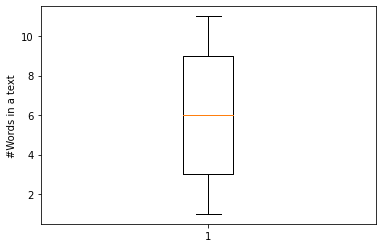

In [16]:
plt.boxplot([len(text) for text in X_train], whis=[15, 85], showfliers=False)
plt.ylabel("#Words in a text")
plt.show()

In [17]:
maxsequence = 15
X_train = pad_sequences(X_train, maxlen=maxsequence)

In [18]:
X_train

array([[   0,    0,    0, ...,   31,  582,  337],
       [   0,    0,    0, ...,  584, 1628,  338],
       [   0,    0,    0, ...,    1,   18,   19],
       ...,
       [   0,    0,    0, ...,    4,  117,   39],
       [   0,    0,    0, ...,  354, 3267,  258],
       [   0,    0,    0, ...,  393,   88,    9]])

In [169]:
X_test = pad_sequences(X_test, maxlen=maxsequence)
X_val  = pad_sequences(X_val, maxlen=maxsequence)

In [170]:
# le = LabelEncoder()
# le.fit(train.drop(["text",'position'], axis=1).values)

# y_train = le.transform((train.drop(["text",'position'], axis=1).values).flatten())
# y_test = le.transform((test.drop(["text",'position'], axis=1).values).flatten())

In [171]:
train = pd.get_dummies(train, columns = ['type'])
test = pd.get_dummies(test, columns = ['type'])
val = pd.get_dummies(val, columns = ['type'])


In [172]:
y_train = train.drop(["text",'position'], axis=1).values
y_test = test.drop(["text",'position'], axis=1).values
y_val = val.drop(["text",'position'], axis=1).values

In [173]:
model = Sequential()
model.add(Embedding(input_dim=maxwords, input_length=maxsequence, output_dim=64))
model.add(GlobalAveragePooling1D())
model.add(Dense(5))
model.add(Activation('sigmoid'))

In [174]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 15, 64)            288000    
_________________________________________________________________
global_average_pooling1d_11  (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 5)                 325       
_________________________________________________________________
activation_16 (Activation)   (None, 5)                 0         
Total params: 288,325
Trainable params: 288,325
Non-trainable params: 0
_________________________________________________________________


In [175]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])

In [176]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=50)

Epoch 1/50
129/129 [==============================] - 1s 5ms/step - loss: 0.5873 - accuracy: 0.4891 - val_loss: 0.4733 - val_accuracy: 0.4851
Epoch 2/50
129/129 [==============================] - 0s 4ms/step - loss: 0.4333 - accuracy: 0.5759 - val_loss: 0.4014 - val_accuracy: 0.6180
Epoch 3/50
129/129 [==============================] - 0s 4ms/step - loss: 0.3714 - accuracy: 0.6311 - val_loss: 0.3423 - val_accuracy: 0.6194
Epoch 4/50
129/129 [==============================] - 0s 4ms/step - loss: 0.3153 - accuracy: 0.6541 - val_loss: 0.2920 - val_accuracy: 0.6655
Epoch 5/50
129/129 [==============================] - 0s 4ms/step - loss: 0.2689 - accuracy: 0.7848 - val_loss: 0.2507 - val_accuracy: 0.8643
Epoch 6/50
129/129 [==============================] - 0s 3ms/step - loss: 0.2317 - accuracy: 0.8701 - val_loss: 0.2184 - val_accuracy: 0.8752
Epoch 7/50
129/129 [==============================] - 0s 3ms/step - loss: 0.2022 - accuracy: 0.8822 - val_loss: 0.1928 - val_accuracy: 0.8908
Epoch 

In [177]:
score = model.evaluate(X_test, y_test)
print("Test loss", score[0])
print("Test accuracy", score[1])

139/139 [==============================] - 0s 661us/step - loss: 0.0458 - accuracy: 0.9704
Test loss 0.045828621834516525
Test accuracy 0.9703686833381653


In [178]:
model = Sequential()
model.add(Embedding(maxwords, 64, input_length=maxsequence))
model.add(Conv1D(filters=64, kernel_size=9, padding='same', activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dense(5))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

model.fit(X_train, y_train, batch_size=32, epochs=25, validation_data=(X_val, y_val))

y_pred = model.predict(X_test)
print("AUC score", roc_auc_score(y_test, y_pred))

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, 15, 64)            288000    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 15, 64)            36928     
_________________________________________________________________
global_average_pooling1d_12  (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 5)                 325       
_________________________________________________________________
activation_17 (Activation)   (None, 5)                 0         
Total params: 325,253
Trainable params: 325,253
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
129/129 [==============================] - 1s 6ms/step - loss: 0.4444 - accuracy: 0.5073 - val_loss: 0

In [179]:
model = Sequential()
model.add(Embedding(input_dim=maxwords, input_length=maxsequence, output_dim=64))
model.add(LSTM(32))
model.add(Dense(5))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))

y_pred = model.predict(X_test)
print("AUC score", roc_auc_score(y_test, y_pred))

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 15, 64)            288000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_20 (Dense)             (None, 5)                 165       
_________________________________________________________________
activation_18 (Activation)   (None, 5)                 0         
Total params: 300,581
Trainable params: 300,581
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
129/129 [==============================] - 2s 14ms/step - loss: 0.4406 - accuracy: 0.4896 - val_loss: 0.2953 - val_accuracy: 0.7130
Epoch 2/20
129/129 [==============================] - 2s 13ms/step - loss: 0.2093 - accuracy: 0.8485 -

In [180]:
model = Sequential()
model.add(Embedding(input_dim=maxwords, input_length=maxsequence, output_dim=64))
model.add(GRU(32))
model.add(Dense(5))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

model.fit(X_train, y_train, batch_size=32, epochs=25, validation_data=(X_val, y_val))

y_pred = model.predict(X_test)
print("AUC score", roc_auc_score(y_test, y_pred))

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_28 (Embedding)     (None, 15, 64)            288000    
_________________________________________________________________
gru_9 (GRU)                  (None, 32)                9408      
_________________________________________________________________
dense_21 (Dense)             (None, 5)                 165       
_________________________________________________________________
activation_19 (Activation)   (None, 5)                 0         
Total params: 297,573
Trainable params: 297,573
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
129/129 [==============================] - 1s 10ms/step - loss: 0.4474 - accuracy: 0.4913 - val_loss: 0.2886 - val_accuracy: 0.7734
Epoch 2/25
129/129 [==============================] - 1s 9ms/step - loss: 0.2030 - accuracy: 0.8366 - 

In [181]:
model = Sequential()
model.add(Embedding(input_dim=maxwords, input_length=maxsequence, output_dim=64))
model.add(GRU(32, return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dense(5))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

model.fit(X_train, y_train, batch_size=32, epochs=25, validation_data=(X_val, y_val))

y_pred = model.predict(X_test)
print("AUC score", roc_auc_score(y_test, y_pred))

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_29 (Embedding)     (None, 15, 64)            288000    
_________________________________________________________________
gru_10 (GRU)                 (None, 15, 32)            9408      
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 32)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 5)                 165       
_________________________________________________________________
activation_20 (Activation)   (None, 5)                 0         
Total params: 297,573
Trainable params: 297,573
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
129/129 [==============================] - 1s 10ms/step - loss: 0.4809 - accuracy: 0.4624 - val_loss: 

In [182]:
model = Sequential()
model.add(Embedding(input_dim=maxwords, input_length=maxsequence, output_dim=64))
model.add(Bidirectional(GRU(32)))
model.add(Dense(5))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

model.fit(X_train, y_train, batch_size=32, epochs=25, validation_data=(X_val, y_val))

y_pred = model.predict(X_test)
print("AUC score", roc_auc_score(y_test, y_pred))

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_30 (Embedding)     (None, 15, 64)            288000    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64)                18816     
_________________________________________________________________
dense_23 (Dense)             (None, 5)                 325       
_________________________________________________________________
activation_21 (Activation)   (None, 5)                 0         
Total params: 307,141
Trainable params: 307,141
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
129/129 [==============================] - 2s 13ms/step - loss: 0.4275 - accuracy: 0.5548 - val_loss: 0.2420 - val_accuracy: 0.8311
Epoch 2/25
129/129 [==============================] - 1s 11ms/step - loss: 0.1440 - accuracy: 0.8854 -

In [183]:
model = Sequential()
model.add(Embedding(input_dim=maxwords, input_length=maxsequence, output_dim=64))
model.add(Bidirectional(GRU(32, return_sequences=True)))
model.add(GRU(32))
model.add(Dense(5))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

model.fit(X_train, y_train, batch_size=32, epochs=25, validation_data=(X_val, y_val))

y_pred = model.predict(X_test)
print("AUC score", roc_auc_score(y_test, y_pred))

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_31 (Embedding)     (None, 15, 64)            288000    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 15, 64)            18816     
_________________________________________________________________
gru_13 (GRU)                 (None, 32)                9408      
_________________________________________________________________
dense_24 (Dense)             (None, 5)                 165       
_________________________________________________________________
activation_22 (Activation)   (None, 5)                 0         
Total params: 316,389
Trainable params: 316,389
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
129/129 [==============================] - 3s 20ms/step - loss: 0.3963 - accuracy: 0.5669 - val_loss: 

In [184]:
inp = Input(shape=(maxsequence, ))
x = Embedding(input_dim=maxwords, input_length=maxsequence, output_dim=300)(inp)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(GRU(80, return_sequences=True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPool1D()(x)
conc = concatenate([avg_pool, max_pool])
outp = Dense(5, activation="sigmoid")(conc)

model = Model(inputs=inp, outputs=outp)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

model.fit(X_train, y_train, batch_size=32, epochs=25, validation_data=(X_val, y_val))

y_pred = model.predict(X_test)
print("AUC score", roc_auc_score(y_test, y_pred))

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
embedding_32 (Embedding)        (None, 15, 300)      1350000     input_5[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_4 (SpatialDro (None, 15, 300)      0           embedding_32[0][0]               
__________________________________________________________________________________________________
bidirectional_6 (Bidirectional) (None, 15, 160)      183360      spatial_dropout1d_4[0][0]        
_______________________________________________________________________________________

In [185]:
def load_vectors_words(fname, words):
    """Loads embeddings from a FastText file. Only loads embeddings for the given dictionary of words"""
    data = {}
    with open(fname, encoding='utf-8') as fin:
        next(fin)  # Skip first line, just contains embeddings size data
        for line in fin:
            tokens = line.rstrip().split(' ')
            word = tokens[0]
            if word in words:
                data[word] = np.array(list(map(float, tokens[1:])))
    return data

In [186]:
FASTTEXT_FILE = "C:/Users/coque/OneDrive/Desktop/TFM/crawl-300d-2M.vec"
embeddings = load_vectors_words(FASTTEXT_FILE, tokenizer.word_index)

In [187]:
embeddings["the"]

array([ 2.310e-02,  1.700e-02,  1.570e-02, -7.730e-02,  1.088e-01,
        3.100e-03, -1.487e-01, -2.672e-01, -3.570e-02, -4.870e-02,
        8.070e-02,  1.532e-01, -7.390e-02, -2.910e-02, -4.450e-02,
       -1.400e-03,  1.014e-01,  1.860e-02, -2.530e-02,  2.000e-02,
       -2.600e-03, -1.790e-02,  5.000e-04,  5.400e-03, -1.340e-02,
        2.330e-02, -7.550e-02, -1.560e-02,  4.150e-02, -4.985e-01,
        4.100e-02, -6.160e-02,  4.700e-03,  3.250e-02, -1.620e-02,
       -1.720e-02,  9.880e-02,  7.660e-02, -7.960e-02, -3.450e-02,
        1.240e-02, -1.007e-01, -2.920e-02, -7.620e-02, -1.261e-01,
       -5.310e-02,  4.240e-02,  1.440e-02, -6.830e-02,  2.859e-01,
        3.990e-02,  2.010e-02,  3.240e-01, -6.560e-02, -4.970e-02,
        9.000e-03,  9.020e-02, -1.380e-02, -4.120e-02, -2.970e-02,
        3.139e-01, -1.428e-01,  1.660e-02, -2.190e-02, -5.750e-02,
        1.359e-01, -1.655e-01,  1.900e-03,  3.230e-02, -1.300e-03,
       -3.033e-01, -9.100e-03,  1.462e-01,  1.860e-01, -5.240e

In [188]:
def create_embedding_matrix(embeddings, tokenizer):
    """Creates a weight matrix for an Embedding layer using an embeddings dictionary and a Tokenizer"""
    
    # Compute mean and standard deviation for embeddings
    all_embs = np.stack(embeddings.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    
    embedding_size = len(next(iter(embeddings.values())))
    
    embedding_matrix = np.random.normal(emb_mean, emb_std, (tokenizer.num_words, embedding_size))
    for word, i in tokenizer.word_index.items():
        if i >= tokenizer.num_words: break
        embedding_vector = embeddings.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
            
    return embedding_matrix

In [189]:
embedding_matrix = create_embedding_matrix(embeddings, tokenizer)

C:\Users\coque\anaconda3\envs\tensor\lib\site-packages\IPython\core\interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [190]:
embedding_matrix.shape

(4500, 300)

In [191]:
pretrained = Embedding(maxwords, embedding_matrix.shape[1], weights=[embedding_matrix], trainable=False)

In [192]:
inp = Input(shape=(maxsequence, ))
x = Embedding(maxwords, embedding_matrix.shape[1], weights=[embedding_matrix], trainable=False)(inp)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(GRU(80, return_sequences=True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPool1D()(x)
conc = concatenate([avg_pool, max_pool])
outp = Dense(5, activation="sigmoid")(conc)

model = Model(inputs=inp, outputs=outp)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

model.fit(X_train, y_train, batch_size=32, epochs=25, validation_data=(X_val, y_val))

y_pred = model.predict(X_test)
print("AUC score", roc_auc_score(y_test, y_pred))

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
embedding_34 (Embedding)        (None, 15, 300)      1350000     input_6[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_5 (SpatialDro (None, 15, 300)      0           embedding_34[0][0]               
__________________________________________________________________________________________________
bidirectional_7 (Bidirectional) (None, 15, 160)      183360      spatial_dropout1d_5[0][0]        
_______________________________________________________________________________________

In [193]:
X_test

array([[   0,    0,    0, ...,  101,  281,  556],
       [   0,    0,    0, ...,    0,    0,   25],
       [   0,    0,    0, ...,  296, 1081,  202],
       ...,
       [   0,    0,    0, ...,    0,    0,  136],
       [   0,    0,    0, ...,    0,    0, 2442],
       [   0,    0,    0, ...,   37,  596,   74]])

In [231]:
test = pd.read_csv('C:/Users/coque/OneDrive/Desktop/TFM/csv/8MM.csv')
test = test['text']

In [197]:
X_test = tokenizer.texts_to_sequences(test)

In [198]:
X_test = pad_sequences(X_test, maxlen=maxsequence)

In [207]:
y_pred = model.predict(X_test)

In [208]:
y_pred

array([[3.9667707e-06, 5.2151084e-04, 2.5185347e-03, 9.9996132e-01,
        1.6340613e-04],
       [9.2775244e-01, 7.9837441e-04, 1.4260632e-01, 1.5492207e-05,
        2.0356774e-03],
       [9.9999797e-01, 1.4103610e-05, 1.6361994e-06, 6.9699245e-06,
        3.9768197e-06],
       ...,
       [2.7669201e-05, 2.8753281e-04, 9.9997205e-01, 2.3979863e-05,
        1.5992262e-05],
       [3.7141442e-03, 1.8972725e-02, 9.9420261e-01, 7.6177716e-04,
        9.8633766e-04],
       [4.8029512e-02, 8.3641726e-06, 9.9094033e-01, 1.0265988e-05,
        1.5210908e-06]], dtype=float32)

In [209]:
predicted = np.argmax(y_pred, axis=-1)

In [215]:
predicted.shape

(4830,)

In [212]:
y_train.labels()

AttributeError: 'numpy.ndarray' object has no attribute 'labels'

In [222]:
labels = sorted(list(set(star_wars.type)))

In [225]:
predicciones  = [labels[i] for i in predicted]

In [229]:
test['type']=predicciones

In [238]:
prueba_final = pd.DataFrame({'text':list(test),'type':predicciones})

In [241]:
pd.set_option('display.max_rows', prueba_final.shape[0]+1)
pd.set_option('display.max_colwidth', None)

In [248]:
prueba_final[prueba_final.type == 'character']

,text,type
1277,MARY'S VOICE (V.O.),character
1373,MARY'S VOICE (V.O.),character
1392,MARY'S VOICE (V.O.),character
1403,MARY'S VOICE (V.O.),character
1409,"MARY'S VOICE (V.O., cont)",character
1415,"MARY'S VOICE (V.O., cont)",character
1422,"MARY'S VOICE (V.O., cont)",character
1427,"MARY'S VOICE (V.O., cont)",character
1433,"MARY'S VOICE (V.O., cont)",character
1439,"MARY'S VOICE (V.O., cont)",character


In [249]:
prueba_final

,text,type
0,"INT. MIAMI AIRPORT, TERMINAL -- DAY",localization
1,Amongst the weary tourist families and solitary businessmen,accion
2,"sits TOM WELLES, middle-aged, hair neat, suit crisp and",accion
3,"gray. He's eating crackers from a cellophane package,",dialogue
4,"sipping soda from a paper cup, watching an ARRIVAL GATE.",dialogue
5,AT THE GATE,accion
6,"leading the pack, except for a handsome YOUNG REPUBLICAN poster boy hurrying along.",accion
7,ACROSS THE TERMINAL,accion
8,Welles gets up and FOLLOWS...,accion
9,"EXT. MIAMI AIRPORT, CURBSIDE -- DAY",localization
